In [2]:
%pip install lifelines
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install latex
%pip install xelatex


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex


In [1]:
# call packages
from lifelines import CoxPHFitter
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.utils import median_survival_times
#Suggest using higher row numbers around 1.5 mill
df = pd.read_csv("Cancer5.csv", low_memory=False)
df.head()

,Age recode with <1 year olds,Sex,Year of diagnosis,"Race recode (W, B, AI, API)",Site recode ICD-O-3/WHO 2008,Primary Site,AJCC ID (2018+),Radiation recode (2003+),"Chemotherapy recode (yes, no/unk) (2004+)",Months from diagnosis to treatment,COD to site recode,SEER cause-specific death classification,Survival months,Year of death recode,Year of follow-up recode,Patient ID,Median household income inflation adj to 2021,Combined Summary Stage (2004+),Total number of in situ/malignant tumors for patient
0,40-44 years,Male,2002,White,Testis,629,Blank(s),Blank(s),Blank(s),000,Alive,Alive or dead of other cause,0220,Alive at last contact,2020,17,"$75,000+",Blank(s),02
1,65-69 years,Male,2000,White,Rectum,209,Blank(s),Blank(s),Blank(s),001,Rectum and Rectosigmoid Junction,Dead (attributable to this cancer dx),0049,2004,2004,18,"$75,000+",Blank(s),02
2,35-39 years,Female,2008,White,Rectosigmoid Junction,199,Blank(s),Beam radiation,Yes,000,Alive,Alive or dead of other cause,0155,Alive at last contact,2020,26,"$75,000+",Distant,02
3,60-64 years,Female,2008,White,"Trachea, Mediastinum and Other Respiratory Organs",381,Blank(s),None/Unknown,No/Unknown,000,"Trachea, Mediastinum and Other Respiratory Organs",Dead (attributable to this cancer dx),0000,2008,2008,40,"$75,000+",Localized,02
4,85+ years,Male,2008,White,Melanoma of the Skin,444,Blank(s),None/Unknown,No/Unknown,000,Other Cause of Death,Alive or dead of other cause,0026,2011,2011,46,"$75,000+",Localized,02


In [2]:
#Some Data cleaning here
df = df.replace('Blank(s)', np.nan)
df['Sex'] = pd.factorize(df['Sex'])[0]
df = df.replace('Unknown', np.nan)
df['Survival months'] = pd.to_numeric(df['Survival months'])
df['alive_dead'] = df['Year of death recode'].str.contains('Alive')
df["alive_dead"] = df["alive_dead"].astype(int)
df["alive_dead"] = df["alive_dead"].replace({0:1, 1:0}) #has to be 1 for alive 0 for dead
df.loc[:, 'Survival months'].mean()
df = df.drop(df[df['COD to site recode'] == 'Other Cause of Death'].index) #drops Other Cause of death in COD we only want Cancer
df = df.drop(df[df['SEER cause-specific death classification'] == 'Dead (missing/unknown COD)'].index) #Remove Missing
df = df.drop(df[(df['SEER cause-specific death classification'] == 'Alive or dead of other cause') & (df['COD to site recode'] != 'Alive')].index) #Making sure we get rid of non cancer deaths.
df['Total number of in situ/malignant tumors for patient'] = df['Total number of in situ/malignant tumors for patient'].str.lstrip('0')

In [5]:
df['Median household income inflation adj to 2021'].value_counts

<bound method IndexOpsMixin.value_counts of 0                                         $75,000+
1                                         $75,000+
2                                         $75,000+
3                                         $75,000+
5                                         $75,000+
                             ...                  
12809520                         $65,000 - $69,999
12809521                                  $75,000+
12809522                         $40,000 - $44,999
12809523                         $65,000 - $69,999
12809524    Unknown/missing/no match/Not 1990-2021
Name: Median household income inflation adj to 2021, Length: 10355265, dtype: object>

In [3]:
df.replace(['None/Unknown','No/Unknown','Unknown/missing/no match/Not 1990-2021','Not available (IL or NY)'], np.nan, inplace=True)
df.head()

,Age recode with <1 year olds,Sex,Year of diagnosis,"Race recode (W, B, AI, API)",Site recode ICD-O-3/WHO 2008,Primary Site,AJCC ID (2018+),Radiation recode (2003+),"Chemotherapy recode (yes, no/unk) (2004+)",Months from diagnosis to treatment,COD to site recode,SEER cause-specific death classification,Survival months,Year of death recode,Year of follow-up recode,Patient ID,Median household income inflation adj to 2021,Combined Summary Stage (2004+),Total number of in situ/malignant tumors for patient,alive_dead
0,40-44 years,0,2002,White,Testis,629,NaN,NaN,NaN,000,Alive,Alive or dead of other cause,220.0,Alive at last contact,2020,17,"$75,000+",NaN,2,0
1,65-69 years,0,2000,White,Rectum,209,NaN,NaN,NaN,001,Rectum and Rectosigmoid Junction,Dead (attributable to this cancer dx),49.0,2004,2004,18,"$75,000+",NaN,2,1
2,35-39 years,1,2008,White,Rectosigmoid Junction,199,NaN,Beam radiation,Yes,000,Alive,Alive or dead of other cause,155.0,Alive at last contact,2020,26,"$75,000+",Distant,2,0
3,60-64 years,1,2008,White,"Trachea, Mediastinum and Other Respiratory Organs",381,NaN,NaN,NaN,000,"Trachea, Mediastinum and Other Respiratory Organs",Dead (attributable to this cancer dx),0.0,2008,2008,40,"$75,000+",Localized,2,1
5,75-79 years,1,2003,White,Breast,506,NaN,NaN,NaN,000,Breast,Dead (attributable to this cancer dx),14.0,2004,2004,50,"$75,000+",NaN,3,1


In [4]:
df['Income'] = df['Median household income inflation adj to 2021'].str.extract('([\d,\.]+)')
df['Income'] = df['Income'].str.replace(',', '', regex=True).astype(float)
replacement_dict = {'In situ': 0, 'Localized': 1, 'Regional': 2, 'Distant': 4, 'Unknown/unstaged': np.nan}
df['stage'] = df['Combined Summary Stage (2004+)'].replace(replacement_dict)
df['Late or early'] = np.where(df['stage'] <= 1, 1, 0)

In [9]:
df['Survival months'].value_counts()

Survival months
0.0      583469
1.0      395555
2.0      312451
3.0      248864
4.0      217166
          ...  
250.0      9118
251.0      9033
245.0      8992
248.0      8883
240.0      8869
Name: count, Length: 252, dtype: int64

In [5]:
#Wasent sure which age to use since the starting one is a range I decided to use the start age which is the age they were when they got cancer
df['age'] = df['Age recode with <1 year olds'].str.extract('(\d+)') #Grabs first age from range
#df['ageg1'] = pd.to_numeric(df['ageg1'])
#df['Age recode with <1 year olds'] = df['Age recode with <1 year olds'].replace({'^[^\d]*(\d+)'}, '', regex=True)
#df['ageg2'] = df['Age recode with <1 year olds'].str.extract('(\d+)')
#df['ageg2'].fillna(df['ageg1'], inplace=True)
#df['ageg2'] = pd.to_numeric(df['ageg2'])
#3col = df.loc[: , "ageg1":"ageg2"]
#df['age'] = col.mean(axis=1)
#df['avg_age'] =  (df['age'] / 5).round().astype(int) * 5

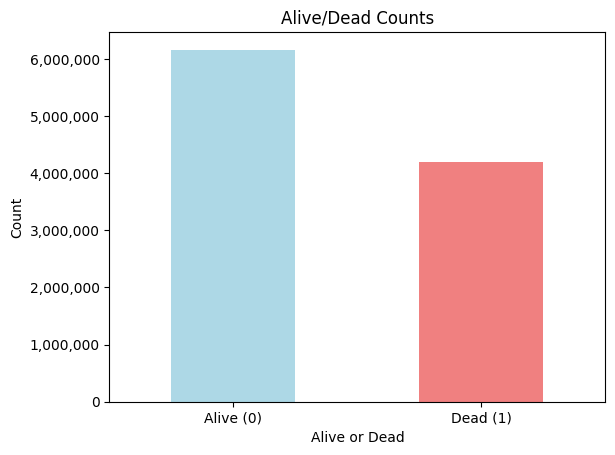

In [6]:
counts = df['alive_dead'].value_counts()
ax = counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
# Customize x-axis labels
ax.set_xticklabels(['Alive (0)', 'Dead (1)'], rotation=0)

# Customize y-axis labels and format
ax.set_ylabel('Count')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Adding title
plt.title('Alive/Dead Counts')
plt.xlabel('Alive or Dead')
# Show the plot
plt.show()

In [17]:
df['Sex'].value_counts()

Sex
1    5140511
0    5058301
Name: count, dtype: int64

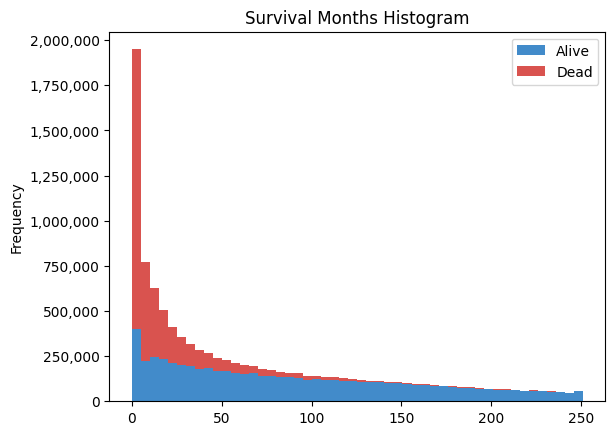

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df contains the necessary columns like 'Survival months' and 'alive_dead'
df = df.dropna(subset=['Survival months', 'alive_dead'])
T = df["Survival months"]
E = df["alive_dead"]
alive_data = T[E == 0]
dead_data = T[E == 1]
plt.hist([alive_data, dead_data], bins=50, color=['#428bca', '#d9534f'], label=['Alive', 'Dead'], stacked=True)
plt.ylabel('Frequency')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Survival Months Histogram')
plt.legend()
plt.show()


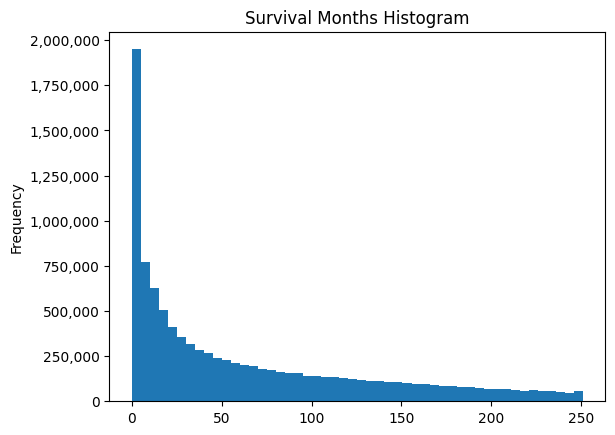

In [8]:
df = df.dropna(subset=['Survival months', 'alive_dead'])
T = df["Survival months"]
E = df["alive_dead"]
plt.hist(T, bins = 50)
plt.ylabel('Frequency')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.title('Survival Months Histogram')
plt.show()

<Axes: xlabel='timeline'>

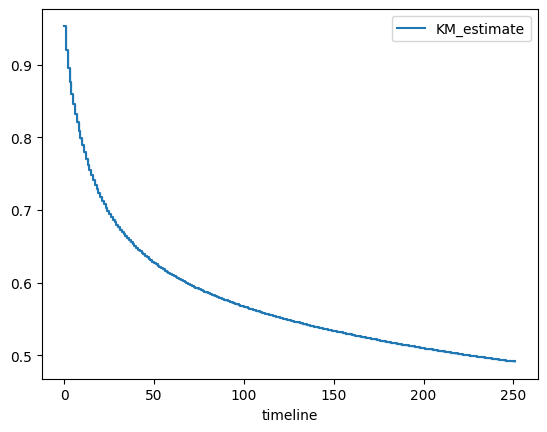

In [19]:
kmf = KaplanMeierFitter()
kmf.fit(durations=T, event_observed=E)
kmf.plot()

In [20]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)


225.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   224.0                   226.0


Median Survival Time - Male: 167.0
Median Survival Time - Female: inf


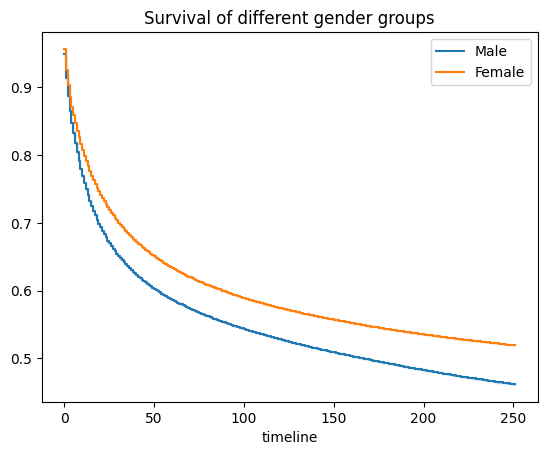

In [14]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

m = (df["Sex"] == 0)
kmf.fit(durations=T[m], event_observed=E[m], label="Male")
kmf.plot_survival_function()

median_survival_male = kmf.median_survival_time_
print("Median Survival Time - Male:", median_survival_male)

kmf.fit(durations=T[~m], event_observed=E[~m], label="Female")
kmf.plot_survival_function()
median_survival_female = kmf.median_survival_time_
print("Median Survival Time - Female:", median_survival_female)
plt.title("Survival of different gender groups")
plt.show()

Text(0.5, 1.0, 'Survival of different gender group')

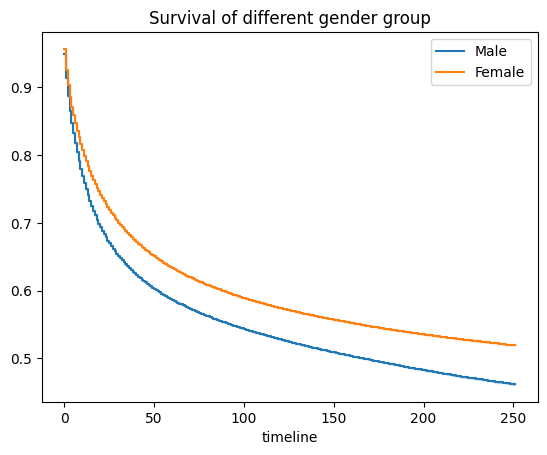

In [24]:
ax = plt.subplot(111)
m = (df["Sex"] == 0)
kmf.fit(durations = T[m], event_observed = E[m], label = "Male")
kmf.plot_survival_function(ax = ax)
kmf.fit(T[~m], event_observed = E[~m], label = "Female")
kmf.plot_survival_function(ax = ax, at_risk_counts = False)
plt.title("Survival of different gender group")

In [21]:
# create dummy col issues with visualization but I was worried that concat would create issues where the model sees patterns with numbers on accident. I probobaly need to use like the 
df = pd.get_dummies(df, columns=['Radiation recode (2003+)'], dtype=float, prefix= 'Rad')
df = pd.get_dummies(df, columns=['Race recode (W, B, AI, API)'], dtype=float, prefix= 'Race')
df = pd.get_dummies(df,columns=['Site recode ICD-O-3/WHO 2008'], dtype=float, prefix= 'Cancer Type')
df['chemo'] = pd.factorize(df['Chemotherapy recode (yes, no/unk) (2004+)'])[0]

In [22]:
#subset data into what I am currently using
#ad back count of tumors
df_test = df[['age', 'alive_dead', 'Survival months', 'Sex','Months from diagnosis to treatment','chemo','Income','stage','Late or early','Total number of in situ/malignant tumors for patient'] + [col for col in df if col.startswith('Cancer Type') or col.startswith('Race') or col.startswith('Rad')]]
#df_test = df_test.drop(df_test[df_test['Survival months'] > 200].index) 
# above line used to drop rows mostly used when testing stuff
df_test = df_test.dropna()

In [23]:
cph = CoxPHFitter(penalizer=0.1, l1_ratio=0)
cph.fit(df_test, duration_col='Survival months', event_col='alive_dead')
coxsumm = cph.print_summary()

C:\Users\nates\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lifelines\utils\__init__.py:1102: ConvergenceWarning: Column(s) ['Cancer Type_Pleura'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 5.5908e+06 total observations, 3.87401e+06 right-censored observations>
             duration col = 'Survival months'
                event col = 'alive_dead'
                penalizer = 0.1
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 5.5908e+06
number of events observed = 1.71679e+06
   partial log-likelihood = -24801496.62
         time fit was run = 2023-12-08 14:44:22 UTC

---
                                                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                             
age                                                             0.02       1.02       0.00             0.02             0.02                 1.02                 1.02
Sex                                                            -0.13       0.88       0.00            -0.13            -0.13                 0.88                 0.88
Months from diagnosis to treatment                             -0.05       0.95       0.00            -0.05            -0.05                 0.95                 0.95
chemo                                                           0.17       1.19       0.00             0.17             0.18                 1.19                 1.19
Income                                                         -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
stage                                                           0.39       1.48       0.00             0.39             0.40                 1.48                 1.49
Late or early                                                  -0.51       0.60       0.00            -0.52            -0.51                 0.60                 0.60
Total number of in situ/malignant tumors for patient           -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
Rad_Beam radiation                                              0.13       1.14       0.00             0.12             0.13                 1.13                 1.14
Rad_Combination of beam with implants or isotopes              -0.12       0.88       0.01            -0.14            -0.11                 0.87                 0.90
Rad_Not available (IL or TX)                                    0.03       1.03       0.00             0.02             0.03                 1.02                 1.03
Rad_Radiation, NOS  method or source not specified              0.24       1.27       0.01             0.22             0.26                 1.25                 1.30
Rad_Radioactive implants (includes brachytherapy) (1988+)      -0.25       0.78       0.01            -0.26            -0.23                 0.77                 0.79
Rad_Radioisotopes (1988+)                                      -0.41       0.66       0.01            -0.43            -0.40                 0.65                 0.67
Rad_Recommended, unknown if administered                       -0.04       0.96       0.01            -0.05            -0.02                 0.95                 0.98
Rad_Refused (1988+)                                             0.28       1.33       0.01             0.27             0.30                 1.31                 1.35
Race_American Indian/Alaska Native                              0.08       1.09       0.01             0.07             0.10                 1.07                 1.11
Race_Asian or Pacific Islander                                 -0.09       0.91       0.00            -0.10            -0.09                 0.91                 0.92
Race_Black                                                      0.14       1.15       0.00             0.13             0.14                 1.14                 1.16
Race_White             

In [30]:
df_test['stage'].value_counts()

stage
1.0    2799988
2.0    1403880
4.0    1272749
0.0     114180
Name: count, dtype: int64

In [84]:
#checking some of the model manually
X = df_test

cph.predict_survival_function(X)
cph.predict_median(X)
cph.predict_partial_hazard(X)

2          2.022610
3          0.885705
9          1.401283
13         0.506977
14         0.755279
             ...   
1499995    5.936973
1499996    5.240924
1499997    0.517772
1499998    0.959454
1499999    0.220334
Length: 817408, dtype: float64

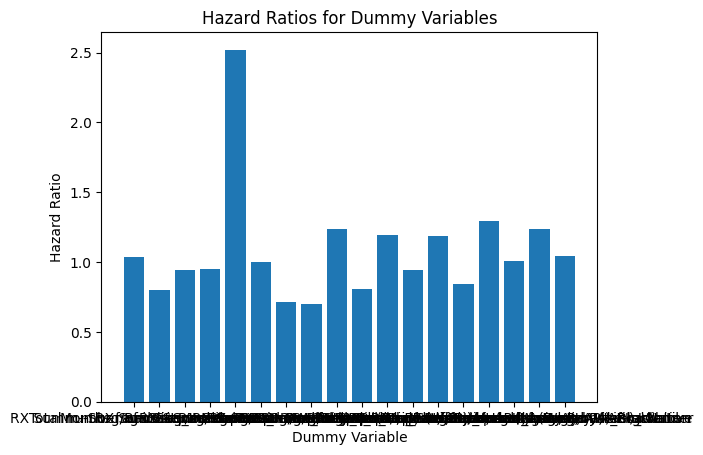

In [35]:

coefficients = cph.summary['exp(coef)']
# Create a bar plot not a good one I am working on it I have a lot of dummy col
plt.bar(coefficients.index, coefficients)
plt.xlabel('Dummy Variable')
plt.ylabel('Hazard Ratio')
plt.title('Hazard Ratios for Dummy Variables')
plt.show()

<Axes: >

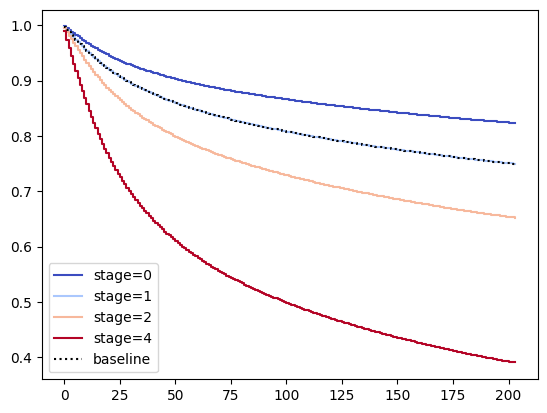

In [70]:
#look at specific covariates
cph.plot_partial_effects_on_outcome(covariates = 'stage', values = [0,1,2,4], cmap = 'coolwarm')


<Axes: >

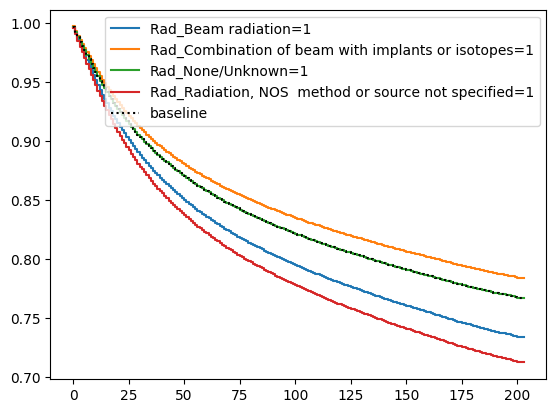

In [86]:
selected_columns = [col for col in df_test.columns if col.startswith('Rad')][:4] 
cph.plot_covariate_groups(selected_columns, np.eye(len(selected_columns)))

In [ ]:
# checks assumptions
cph.check_assumptions(df_test, p_value_threshold = 0.05) 